In [2]:
import os, sys
BASE_PATH = os.path.dirname(os.path.abspath(''))
print(BASE_PATH)
sys.path.append(BASE_PATH)

/root/sn6_clone


In [6]:
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from datagen.dg_cfg import dg_cfg
from lib.viz import show_hist, show_stats

loading ../../image_folder/processed/pan/fold2_o1-00-50.tfrec
1


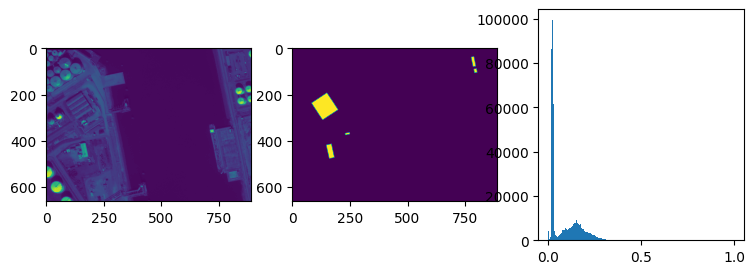

shape: (664, 891, 1)
   min  max      mean      std     pos  zero  neg  nan
0  0.0  1.0  0.099674  0.11194  587359  4265    0    0
b'SN6_Train_AOI_11_Rotterdam_PAN_20190804111224_20190804111453_tile_8679'


In [9]:
def test_tfrec(show=4):
    TFREC_FORMAT = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.string),
        'data_idx': tf.io.VarLenFeature(tf.int64),
        'fn': tf.io.FixedLenFeature([], tf.string),
        'orient': tf.io.FixedLenFeature([], tf.int64),
    }

    def _read_tfrecord(feature):
        features = tf.io.parse_single_example(feature, TFREC_FORMAT)
        image = tf.io.parse_tensor(features["image"], tf.float32)
        label = tf.io.parse_tensor(features["label"], tf.bool)
        label = tf.cast(label, tf.float32)

        data_idx = tf.sparse.to_dense(features["data_idx"])
        h = data_idx[1] - data_idx[0]
        w = data_idx[3] - data_idx[2]
        image = tf.reshape(image, [h, w, len(dg_cfg['channel'])])
        label = tf.reshape(label, [h, w, 1])

        image = tf.math.divide(image, tf.math.reduce_max(image))
        fn = features['fn']

        return image, label, fn

    filenames = glob.glob(os.path.join(dg_cfg['out_dir'], f'*.tfrec'))
    filename = filenames[0]
    print(f'loading {filename}')
    ds = tf.data.TFRecordDataset([filename])
    ds = ds.map(_read_tfrecord)

    for img, label, fn in ds.take(show):
        f,[ax1,ax2,ax3] = plt.subplots(1,3,figsize=(9,3))
        ax1.imshow(img.numpy()[:,:,0])
        ax2.imshow(label.numpy()[:,:,0])
        show_hist(img.numpy(),ax=ax3)
        plt.show()
    
    show_stats(img.numpy())
    print(fn.numpy())

test_tfrec()